In [2]:
import os
import json
import cv2
import numpy as np
import tensorflow as tf
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import BatchNormalization, Conv2D, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
class BBoxProcessor:
    def __init__(self, coco_json_path):
        self.load_coco_data(coco_json_path)
        self.input_size = 96
        
        # Ensure unique class names and proper background handling
        self.class_names = ['background'] + sorted(list(set([c['name'] for c in self.coco['categories']])))
        self.num_classes = len(self.class_names) - 1  # exclude background
        
    def load_coco_data(self, path):
        with open(path) as f:
            self.coco = json.load(f)
        self._create_mappings()
        
    def _create_mappings(self):
        self.image_id_to_file = {img['id']: img['file_name'] for img in self.coco['images']}
        self.image_id_to_size = {img['id']: (img['width'], img['height']) for img in self.coco['images']}
        self.image_id_to_annots = defaultdict(list)
        for annot in self.coco['annotations']:
            self.image_id_to_annots[annot['image_id']].append(annot)
    
    def convert_bbox(self, bbox, img_width, img_height):
        """Convert COCO bbox [x,y,w,h] to relative coordinates [0-1]"""
        x, y, w, h = bbox
        return [
            max(0, x / img_width),  
            max(0, y / img_height), 
            min(1, w / img_width),  
            min(1, h / img_height)  
        ]
    
    def process_bboxes(self, image_id, debug=False):
        """Process bboxes for a single image with debug info"""
        file_name = self.image_id_to_file[image_id]
        img_width, img_height = self.image_id_to_size[image_id]
        annots = self.image_id_to_annots[image_id]
        
        bboxes = []
        labels = []
        class_ids = []
        
        if debug:
            print(f"\n=== Debug BBox Processing for Image {image_id} ===")
            print(f"Original size: {img_width}x{img_height}")
            print(f"Found {len(annots)} annotations")
            print(f"Available classes: {self.class_names}")
        
        for i, annot in enumerate(annots):
            # Convert bbox coordinates
            abs_bbox = annot['bbox']
            rel_bbox = self.convert_bbox(abs_bbox, img_width, img_height)
            
            # One-hot encoding
            class_id = annot['category_id']
            # Map class_id to index (assuming class_ids start from 1)
            class_idx = class_id - 1  
            one_hot = tf.one_hot(class_idx, depth=self.num_classes)
            
            bboxes.append(rel_bbox)
            labels.append(one_hot)
            class_ids.append(class_id)
            
            if debug:
                print(f"Annotation {i}:")
                print(f"  Class: {class_id} ({self.class_names[class_id]})")
                print(f"  Absolute bbox: {abs_bbox}")
                print(f"  Relative bbox: {[round(x, 3) for x in rel_bbox]}")
        
        return np.array(bboxes), np.array(labels), np.array(class_ids)
    
    def create_bbox_dataset(self, image_ids, image_dir, batch_size=32, shuffle=False):
        """Create tf.data.Dataset for bbox processing"""
        max_bboxes = max(len(self.image_id_to_annots[img_id]) for img_id in image_ids) if image_ids else 1
        
        def process_image(image_id):
            image_id = image_id.numpy() if hasattr(image_id, 'numpy') else image_id
            file_name = self.image_id_to_file[image_id]
            image_path = os.path.join(image_dir, file_name)
            
            # Load image
            img = tf.io.read_file(image_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, [self.input_size, self.input_size])
            img = tf.cast(img, tf.float32) / 255.0
            
            # Process bboxes
            bboxes, labels, _ = self.process_bboxes(image_id)
            bboxes = tf.convert_to_tensor(bboxes, dtype=tf.float32)
            labels = tf.convert_to_tensor(labels, dtype=tf.float32)
            
            bboxes = tf.ensure_shape(bboxes, [None, 4])
            labels = tf.ensure_shape(labels, [None, self.num_classes])
            
            # Pad to max_bboxes
            paddings = [[0, max_bboxes - tf.shape(bboxes)[0]], [0, 0]]
            bboxes = tf.pad(bboxes, paddings, constant_values=-1)
            labels = tf.pad(labels, paddings, constant_values=0)
            
            return img, bboxes, labels
        
        # Create dataset pipeline
        dataset = tf.data.Dataset.from_tensor_slices(image_ids)
        dataset = dataset.map(
            lambda x: tf.py_function(
                func=process_image,
                inp=[x],
                Tout=(tf.float32, tf.float32, tf.float32)
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        def set_shapes(img, bboxes, labels):
            img.set_shape((self.input_size, self.input_size, 3))
            bboxes.set_shape((max_bboxes, 4))
            labels.set_shape((max_bboxes, self.num_classes))
            return img, bboxes, labels
        
        dataset = dataset.map(set_shapes, num_parallel_calls=tf.data.AUTOTUNE)
        
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(image_ids))
        
        return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [4]:
bbox_processor = BBoxProcessor('train\_annotations.coco.json')

all_image_ids = list(bbox_processor.image_id_to_file.keys())
train_ids, val_ids = train_test_split(all_image_ids, test_size=0.2, random_state=42)

train_bbox_ds = bbox_processor.create_bbox_dataset(train_ids, 'train', shuffle=True)
val_bbox_ds = bbox_processor.create_bbox_dataset(val_ids, 'train')

# Debug sample processing
sample_image_id = train_ids[0]
sample_bboxes, sample_labels, sample_class_ids = bbox_processor.process_bboxes(sample_image_id, debug=True)


=== Debug BBox Processing for Image 1791 ===
Original size: 640x640
Found 1 annotations
Available classes: ['background', 'Non Seragam-Lab', 'Seragam-Lab']
Annotation 0:
  Class: 1 (Non Seragam-Lab)
  Absolute bbox: [238, 155, 153, 130]
  Relative bbox: [0.372, 0.242, 0.239, 0.203]


In [5]:
# Cek apakah ada gambar tanpa annotasi
empty_images = [img_id for img_id in all_image_ids if len(bbox_processor.image_id_to_annots[img_id]) == 0]
print(f"Jumlah gambar tanpa annotasi: {len(empty_images)}")

Jumlah gambar tanpa annotasi: 0


In [50]:
# Dapatkan nama file untuk gambar tanpa annotasi
empty_image_files = [bbox_processor.image_id_to_file[img_id] for img_id in empty_images]

print("Daftar gambar tanpa annotasi:")
for file_name in empty_image_files:
    print(f"- {file_name}")

# Jika ingin melihat lengkap dengan ID gambar
print("\nDetail gambar tanpa annotasi:")
for img_id in empty_images:
    print(f"ID: {img_id}, Nama File: {bbox_processor.image_id_to_file[img_id]}")

Daftar gambar tanpa annotasi:

Detail gambar tanpa annotasi:



=== Contoh Data ===
Gambar shape: (96, 96, 3)
Jumlah bbox valid: 1
Bbox valid (relatif): [[0.36875   0.3640625 0.221875  0.2125   ]]
Label valid (one-hot): [[1. 0.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


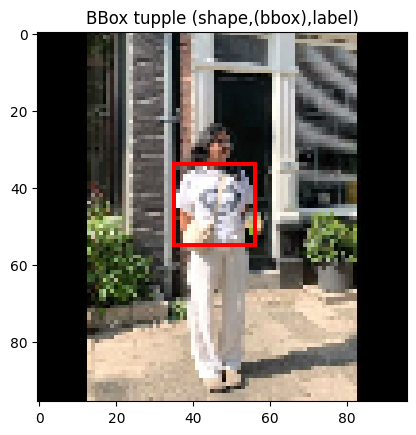

In [6]:
for images, bboxes, labels in train_bbox_ds.take(1):
    print("\n=== Contoh Data ===")
    # Cek gambar pertama dalam batch
    print("Gambar shape:", images[0].shape)
    
    # Create a copy of the image to draw bounding boxes on
    img_with_boxes = images[0].numpy().copy()
    
    # Get image dimensions for scaling
    img_height, img_width = img_with_boxes.shape[0], img_with_boxes.shape[1]
    
    # Cek bbox valid (yang bukan padding)
    valid_mask = tf.reduce_all(bboxes != -1, axis=-1)
    valid_bboxes = bboxes[0][valid_mask[0]]
    valid_labels = labels[0][valid_mask[0]]
    
    print("Jumlah bbox valid:", len(valid_bboxes))
    print("Bbox valid (relatif):", valid_bboxes.numpy())
    print("Label valid (one-hot):", valid_labels.numpy())
    
    # Draw each bounding box on the image
    for bbox in valid_bboxes:
        # Convert relative coordinates back to absolute coordinates
        x_min = int(bbox[0] * img_width)
        y_min = int(bbox[1] * img_height)
        x_max = int((bbox[0] + bbox[2]) * img_width)
        y_max = int((bbox[1] + bbox[3]) * img_height)
        
        # Draw rectangle (using red color with thickness 2)
        cv2.rectangle(img_with_boxes, 
                     (x_min, y_min), 
                     (x_max, y_max), 
                     (255, 0, 0), 1)
    
    # Display the image with bounding boxes
    plt.imshow(img_with_boxes)
    plt.title("BBox tupple (shape,(bbox),label)")
    plt.show()


Initialized seg_map shape: (12, 12, 3)
Background channel sum (should be 144): 144.0

Processing bbox 0:
Original bbox coords (normalized): x=0.372, y=0.242, w=0.239, h=0.203
Class: background (id=1)
Scaled coords (pixels): x1=4, y1=2, x2=7, y2=5
Region size: 3x3
Modified region - top-left: [0. 1. 0.]
Modified region - bottom-right: [0. 1. 0.]
Class 1 pixels added: 9

Verification:
Total background pixels: 135.0
Class 1 pixels: 9.0
Class 2 pixels: 0.0
Invalid pixels at coordinates: []


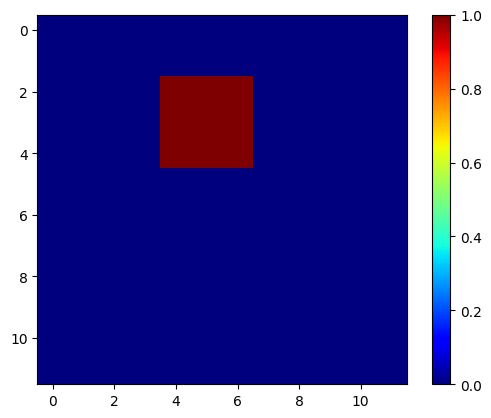

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..253.41676].


Input bboxes: [[0.371875  0.2421875 0.2390625 0.203125 ]]
Input labels: [[1. 0.]]
Class names: ['background', 'Non Seragam-Lab', 'Seragam-Lab']
Label max: [0]


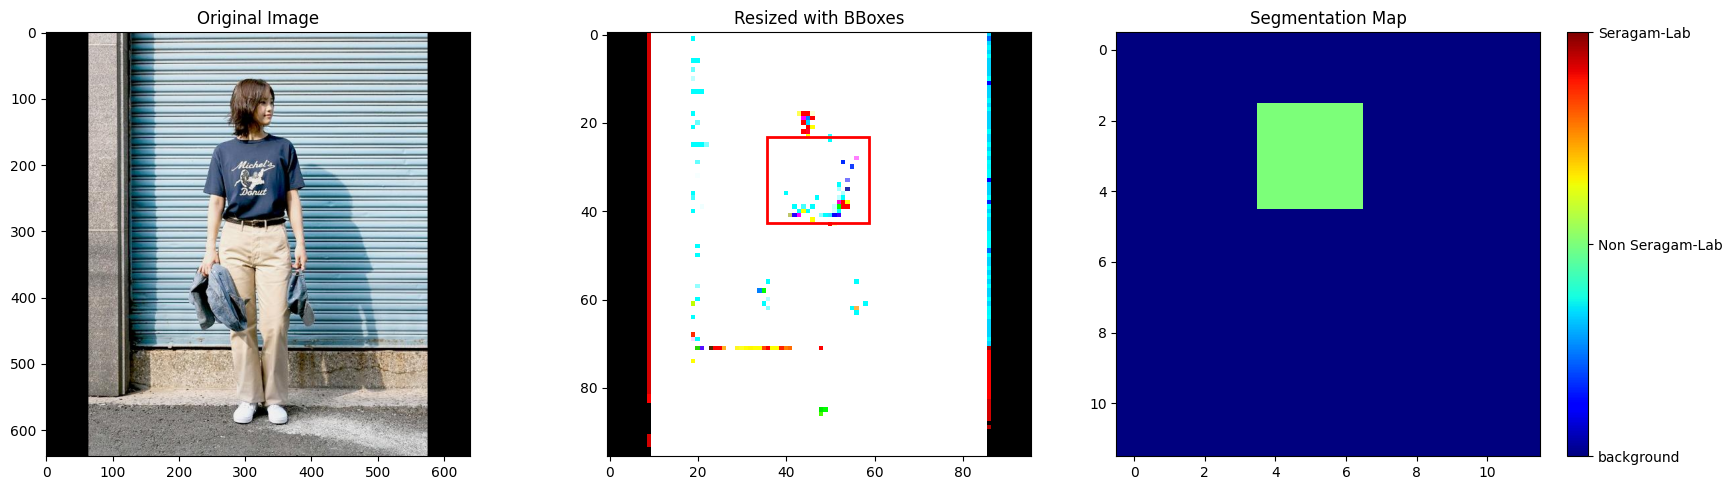

In [7]:
# --------------------------
# Segmentation Processing
# --------------------------

class SegmentationProcessor:
    def __init__(self, bbox_processor, grayscale=True):
        self.bbox_processor = bbox_processor
        self.output_size = self.bbox_processor.input_size // 8  # 12x12
        self.grayscale = grayscale
    
    def bbox_to_segmentation(self, bboxes, labels, debug=False):
        seg_map = np.zeros((self.output_size, self.output_size, 
                        self.bbox_processor.num_classes + 1), dtype=np.float32)
        seg_map[:, :, 0] = 1.0  # Initialize as background

        if debug:
            print(f"\nInitialized seg_map shape: {seg_map.shape}")
            print(f"Background channel sum (should be {self.output_size*self.output_size}): {np.sum(seg_map[:,:,0])}")

        for i, (bbox, label) in enumerate(zip(bboxes, labels)):
            x, y, w, h = bbox
            class_id = np.argmax(label) + 1  # +1 for background
            
            if debug:
                print(f"\nProcessing bbox {i}:")
                print(f"Original bbox coords (normalized): x={x:.3f}, y={y:.3f}, w={w:.3f}, h={h:.3f}")
                print(f"Class: {self.bbox_processor.class_names[class_id-1]} (id={class_id})")

            # Convert and clamp coordinates
            x1 = np.clip(int(x * self.output_size), 0, self.output_size-1)
            y1 = np.clip(int(y * self.output_size), 0, self.output_size-1)
            x2 = np.clip(int((x + w) * self.output_size), 0, self.output_size)
            y2 = np.clip(int((y + h) * self.output_size), 0, self.output_size)

            if debug:
                print(f"Scaled coords (pixels): x1={x1}, y1={y1}, x2={x2}, y2={y2}")
                print(f"Region size: {x2-x1}x{y2-y1}")

            # Only process valid regions
            if x2 > x1 and y2 > y1:
                seg_map[y1:y2, x1:x2, 0] = 0.0    # Remove background
                seg_map[y1:y2, x1:x2, class_id] = 1.0  # Set class
                
                if debug:
                    print(f"Modified region - top-left: {seg_map[y1,x1]}")
                    print(f"Modified region - bottom-right: {seg_map[y2-1,x2-1]}")
                    print(f"Class {class_id} pixels added: {(y2-y1)*(x2-x1)}")
            else:
                if debug:
                    print("!! Invalid region skipped (zero or negative size)")

        # Verify no invalid classes
        if debug:
            print("\nVerification:")
            print(f"Total background pixels: {np.sum(seg_map[:,:,0])}")
            for c in range(1, self.bbox_processor.num_classes + 1):
                print(f"Class {c} pixels: {np.sum(seg_map[:,:,c])}")
            
            invalid_pixels = np.where(np.sum(seg_map, axis=-1) != 1)
            print(f"Invalid pixels at coordinates: {list(zip(invalid_pixels[0], invalid_pixels[1]))}")
        
        if np.any(np.sum(seg_map, axis=-1) != 1):
            raise ValueError("Invalid segmentation map - not properly one-hot encoded")
            
        return seg_map
    
    def create_segmentation_dataset(self, image_ids, image_dir, batch_size=32, shuffle=False):
        """Create tf.data.Dataset for segmentation tasks"""
        def process_image(image_id):
            image_id = image_id.numpy() if hasattr(image_id, 'numpy') else image_id
            file_name = self.bbox_processor.image_id_to_file[image_id]
            image_path = os.path.join(image_dir, file_name)
            
            # Load and preprocess image
            img = tf.io.read_file(image_path)
            img = tf.image.decode_jpeg(img, channels=3)
            if self.grayscale:
                img = tf.image.rgb_to_grayscale(img)
                img = tf.repeat(img, repeats=3, axis=-1)
            img = tf.image.resize(img, [self.bbox_processor.input_size, self.bbox_processor.input_size])
            img = tf.cast(img, tf.float32) / 255.0
            
            # Process bboxes and convert to segmentation map
            bboxes, labels, _ = self.bbox_processor.process_bboxes(image_id)
            seg_map = tf.numpy_function(
                func=self.bbox_to_segmentation,
                inp=[tf.stack(bboxes), tf.stack(labels)],
                Tout=tf.float32
            )
            
            return img, seg_map

        # Create dataset pipeline
        dataset = tf.data.Dataset.from_tensor_slices(image_ids)
        dataset = dataset.map(
            lambda x: tf.py_function(
                func=process_image,
                inp=[x],
                Tout=(tf.float32, tf.float32)
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        def set_shapes(img, seg_map):
            img.set_shape((self.bbox_processor.input_size, self.bbox_processor.input_size, 3))
            seg_map.set_shape((self.output_size, self.output_size, self.bbox_processor.num_classes+1))
            return img, seg_map
        
        dataset = dataset.map(set_shapes, num_parallel_calls=tf.data.AUTOTUNE)
        
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(image_ids))
        
        return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    def visualize_results(self, image_path, bboxes=None, labels=None, seg_map=None):
        """Enhanced visualization with multiple panels"""
        img = plt.imread(image_path)
        resized_img = tf.image.resize(img, [self.bbox_processor.input_size, 
                                          self.bbox_processor.input_size]).numpy()
        
        num_panels = 1
        if bboxes is not None:
            num_panels += 1
        if seg_map is not None:
            num_panels += 1
        
        plt.figure(figsize=(6 * num_panels, 5))
        panel_idx = 1
        
        plt.subplot(1, num_panels, panel_idx)
        plt.imshow(img)
        plt.title("Original Image")
        panel_idx += 1
        
        if bboxes is not None:
            plt.subplot(1, num_panels, panel_idx)
            plt.imshow(resized_img)
            for bbox in bboxes:
                x, y, w, h = bbox
                rect = patches.Rectangle(
                    (x*self.bbox_processor.input_size, y*self.bbox_processor.input_size),
                    w*self.bbox_processor.input_size, h*self.bbox_processor.input_size,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                plt.gca().add_patch(rect)
            plt.title("Resized with BBoxes")
            panel_idx += 1
        
        if seg_map is not None:
            plt.subplot(1, num_panels, panel_idx)
            seg_display = np.argmax(seg_map, axis=-1)
            plt.imshow(seg_display, cmap='jet', vmin=0, 
                      vmax=self.bbox_processor.num_classes)
            
            cbar = plt.colorbar(ticks=range(self.bbox_processor.num_classes + 1))
            cbar.ax.set_yticklabels(self.bbox_processor.class_names)
            
            plt.title("Segmentation Map")
        
        plt.tight_layout()
        plt.show()

seg_processor = SegmentationProcessor(bbox_processor, grayscale=True)


train_seg_ds = seg_processor.create_segmentation_dataset(train_ids, 'train', shuffle=True)
val_seg_ds = seg_processor.create_segmentation_dataset(val_ids, 'train')

sample_seg_map = seg_processor.bbox_to_segmentation(sample_bboxes, sample_labels, debug=True)

# Setelah mendapatkan seg_map
plt.imshow(np.argmax(sample_seg_map, axis=-1), cmap='jet')
plt.colorbar()
plt.show()

print("Input bboxes:", sample_bboxes)
print("Input labels:", sample_labels)

print("Class names:", bbox_processor.class_names)
print("Label max:", np.argmax(sample_labels, axis=1))

sample_file = os.path.join('train', bbox_processor.image_id_to_file[sample_image_id])
seg_processor.visualize_results(
    sample_file, 
    bboxes=sample_bboxes,
    labels=sample_labels,
    seg_map=sample_seg_map
)

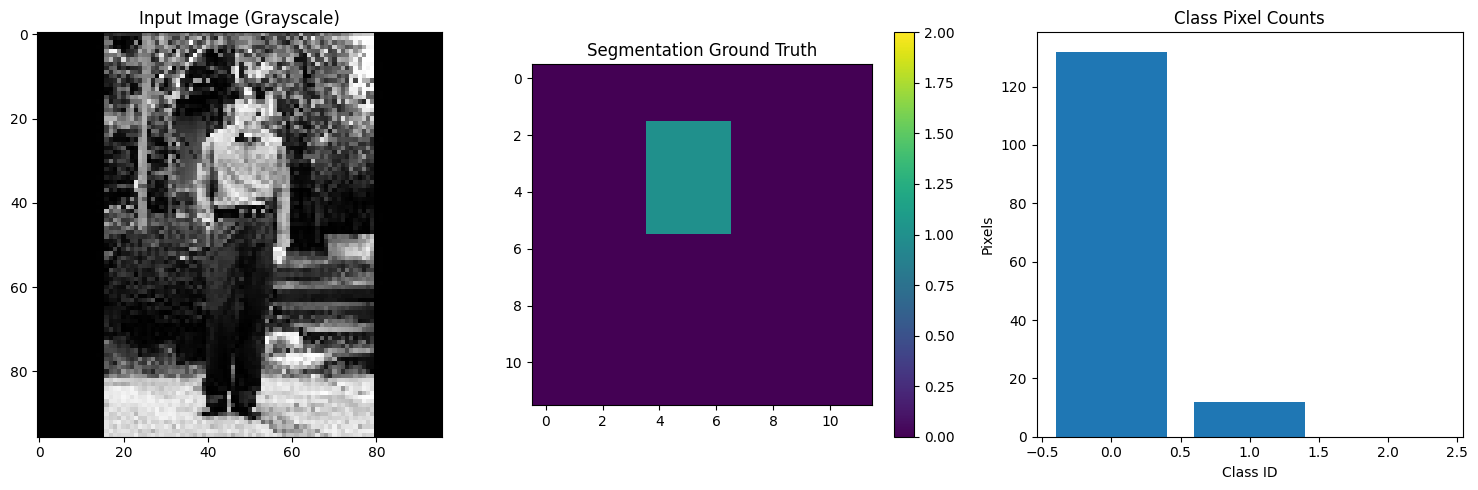

[DEBUG] Model output shape: (None, 12, 12, 3)
Input shape: (32, 96, 96, 3)
Target shape: (32, 12, 12, 3)
Model output shape: (32, 12, 12, 3)
Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 327ms/step - accuracy: 0.2861 - loss: 23.4642 - val_accuracy: 0.3467 - val_loss: 8.9372 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 361ms/step - accuracy: 0.3181 - loss: 7.0558 - val_accuracy: 0.4223 - val_loss: 5.0032 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 302ms/step - accuracy: 0.4215 - loss: 4.8083 - val_accuracy: 0.5013 - val_loss: 4.3290 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 311ms/step - accuracy: 0.4903 - loss: 4.0175 - val_accuracy: 0.5950 - val_loss: 4.0905 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 270ms/step - accuracy: 0.5572 - loss: 3.2261 - val_accuracy: 0.6682 - val_loss: 3.2609 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 360ms/step - accuracy: 0.6037 - loss: 2.8119 - val_

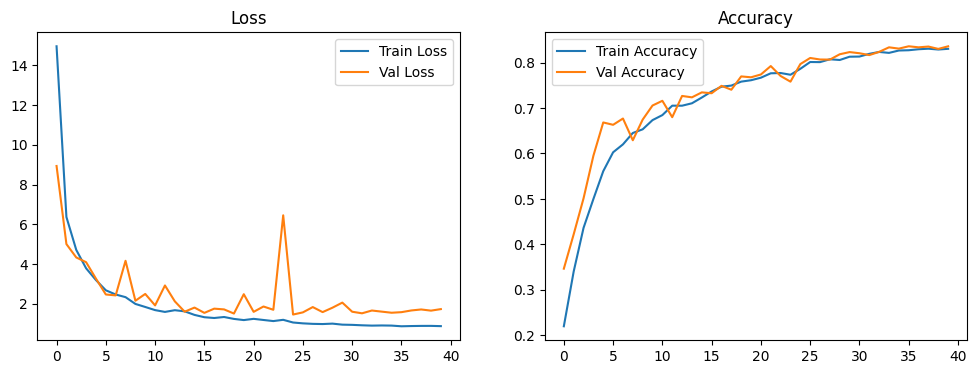

In [53]:
def build_model(input_shape: tuple, weights: str, alpha: float,
                num_classes: int) -> tf.keras.Model:
    """Construct a constrained object detection model."""
    # Create MobileNetV2
    mobile_net_v2 = MobileNetV2(input_shape=input_shape,
                                weights='imagenet',
                               alpha=alpha,
                               include_top=True)
    
    # Speed up batch norm
    for layer in mobile_net_v2.layers:
        if isinstance(layer, BatchNormalization):
            layer.momentum = 0.9
    
    # Cut MobileNet at 1/8th input resolution
    cut_point = mobile_net_v2.get_layer('block_6_expand_relu')
    
    # Add custom head
    model = Conv2D(32, kernel_size=1, activation='relu', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.001))(cut_point.output)  # L2 reg
    model = tf.keras.layers.Dropout(0.3)(model)
    logits = Conv2D(filters=num_classes + 1,  # +1 untuk background
                   kernel_size=1, strides=1,
                   activation=None, name='logits')(model)
    return Model(inputs=mobile_net_v2.input, outputs=logits)


def weighted_cross_entropy(y_true, y_pred, object_weight=10.0):
    """Custom weighted cross entropy loss function."""
    # Create weights tensor - object_weight for object pixels, 1 for background
    y_true = tf.reshape(y_true, tf.shape(y_pred))
    
    # Buat weights tensor
    class_weights = tf.constant([1.0, object_weight, object_weight])  # [background, object]
    weights = tf.reduce_sum(class_weights * y_true, axis=-1)
    
    # Hitung cross entropy
    ce = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    
    return tf.reduce_mean(ce * weights)


def train_model(train_dataset: tf.data.Dataset,
               val_dataset: tf.data.Dataset,
               input_shape: tuple,
               num_classes: int,
               epochs: int = 50,
               batch_size: int = 32,
               lr: float = 0.001,
               alpha: float = 0.35,
               object_weight: float = 100.0):
    """Train a constrained object detection model."""
    
    BEST_MODEL_PATH = "best_model.weights.h5"
    num_classes_with_background = num_classes + 1

    # Validate input shape
    width, height, input_num_channels = input_shape
    if width != height:
        raise Exception(f"Only square inputs are supported; not {input_shape}")

    # Use standard ImageNet weights if input is RGB and alpha is 0.35
    if input_num_channels == 3 and alpha == 0.35:
        weights = 'imagenet'
    else:
        weights = None  # Random initialization

    # Build model
    model = build_model(
        input_shape=input_shape,
        weights=weights,
        alpha=alpha,
        num_classes=num_classes
    )

    print("[DEBUG] Model output shape:", model.output_shape)

    # Model compilation
    model.compile(
        loss=lambda y_true, y_pred: weighted_cross_entropy(y_true, y_pred, object_weight),
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = [
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        ),
        ModelCheckpoint(
            BEST_MODEL_PATH,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )
    ]

    for x, y in train_dataset.take(1):
        print("Input shape:", x.shape)  # Harusnya (batch, 96, 96, 3)
        print("Target shape:", y.shape) # Harusnya (batch, 12, 12, num_classes+1)
        pred = model(x)
        print("Model output shape:", pred.shape) # Harusnya sama dengan target
        break

    # Train model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    # Load best weights and add softmax
    model.load_weights(BEST_MODEL_PATH)
    model = Model(model.input, Softmax()(model.output))
    
    return model, history


def visualize_sample(dataset, num_classes):
    """Visualize samples to verify data"""
    for images, seg_maps in dataset.take(1):
        plt.figure(figsize=(15,5))
        
        # Input image
        plt.subplot(1,3,1)
        plt.imshow(images[0].numpy()[:,:,0], cmap='gray')
        plt.title("Input Image (Grayscale)")
        
        # Segmentation map
        plt.subplot(1,3,2)
        seg_display = np.argmax(seg_maps[0].numpy(), axis=-1)
        plt.imshow(seg_display, vmin=0, vmax=num_classes)
        plt.title("Segmentation Ground Truth")
        plt.colorbar()
        
        # Class distribution
        plt.subplot(1,3,3)
        class_counts = np.sum(seg_maps[0].numpy(), axis=(0,1))
        plt.bar(range(num_classes+1), class_counts)
        plt.title("Class Pixel Counts")
        plt.xlabel("Class ID")
        plt.ylabel("Pixels")
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # Initialize processors

    # Visualize sample data
    NUM_CLASSES = bbox_processor.num_classes
    INPUT_SHAPE = (96, 96, 3)  # Must match BBoxProcessor input_size
    EPOCHS = 50
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    OBJECT_WEIGHT = 100.0
    
    # Visualize dataset sample
    visualize_sample(train_seg_ds, NUM_CLASSES)

    # Train model
    model, history = train_model(
        train_dataset=train_seg_ds,
        val_dataset=val_seg_ds,
        input_shape=INPUT_SHAPE,
        num_classes=NUM_CLASSES,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LEARNING_RATE,
        object_weight=OBJECT_WEIGHT
    )
    
    # Save final model
    model.save('model.h5')
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [57]:
def representative_data_gen():
    for input_value, _ in train_seg_ds.take(100).unbatch().batch(1):
        print(f"Input range: {tf.reduce_min(input_value)} to {tf.reduce_max(input_value)}")  # Should be ~0-1
        yield [tf.cast(input_value, tf.float32)]
    
    # Convert to TFLite with INT8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
    
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)
    

INFO:tensorflow:Assets written to: C:\Users\MSI~1\AppData\Local\Temp\tmpouyl7kcu\assets


INFO:tensorflow:Assets written to: C:\Users\MSI~1\AppData\Local\Temp\tmpouyl7kcu\assets


Saved artifact at 'C:\Users\MSI~1\AppData\Local\Temp\tmpouyl7kcu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_444')
Output Type:
  TensorSpec(shape=(None, 12, 12, 3), dtype=tf.float32, name=None)
Captures:
  1949925012432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1949922807296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1949922817856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1949922813632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1949924802080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1949922808704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1949924793280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1949924791168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1949924798384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1949924801376: TensorSpec(shape=(), dtype=tf.resource, name=Non

d:\Kuliah\SEMESTER 6\CAPSTONE\Object_Detection_v8\OBJ_8\lib\site-packages\tensorflow\lite\python\convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Input range: 0.07069386541843414 to 1.0
Input range: 0.0 to 0.805228590965271
Input range: 0.23387916386127472 to 1.0
Input range: 0.0 to 0.9079521298408508
Input range: 0.22745098173618317 to 1.0
Input range: 0.0 to 0.9790869951248169
Input range: 0.0 to 0.838887631893158
Input range: 0.0 to 0.9389976859092712
Input range: 0.0 to 0.9610010981559753
Input range: 0.0 to 0.9839869141578674
Input range: 0.0 to 0.913725733757019
Input range: 0.0 to 0.8960781693458557
Input range: 0.0 to 0.9915031790733337
Input range: 0.0 to 0.9875811338424683
Input range: 0.013944405131042004 to 1.0
Input range: 0.0 to 0.6833345293998718
Input range: 0.0313725508749485 to 1.0
Input range: 0.0764709860086441 to 1.0
Input range: 0.3211327791213989 to 1.0
Input range: 0.0 to 0.7750547528266907
Input range: 0.0 to 1.0
Input range: 0.0 to 0.8372569680213928
Input range: 0.20392157137393951 to 1.0
Input range: 0.0 to 0.9199342727661133
Input range: 0.05882352963089943 to 1.0
Input range: 0.0 to 0.99836599826812

In [12]:
# Ambil 1 batch dari data training
from tensorflow import keras
from everywhereml.code_generators.tensorflow import convert_model
X_sample, y_sample = next(iter(train_seg_ds))
model = keras.models.load_model('d:\Kuliah\SEMESTER 6\CAPSTONE\Object_Detection_v6\model.h5')

# Konversi model dengan data training
c_header = convert_model(
    model, 
    X_sample, 
    y_sample,
    model_name='UniPredict'
)

# Print hasil
print("X_sample shape:", X_sample.shape)  # e.g., (batch_size, 96, 96, 3)
print("y_sample shape:", y_sample.shape)  # e.g., (batch_size, 12, 12, num_classes+1)
print("\nC Header:")
print(c_header)

TypeError: Error when deserializing class 'DepthwiseConv2D' using config={'name': 'expanded_conv_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'depthwise_regularizer': None, 'depthwise_constraint': None}.

Exception encountered: Unrecognized keyword arguments passed to DepthwiseConv2D: {'groups': 1}